# **Report - Focus Project**

The following is a quick report to keep track of the results for the final submission.

make this nicer-looking

introduction
Structure
Example Usage + Application (vary, to showcase different scenarios)
Tests (same ones, to offer a benchmark for comparison)

## **Linear Congruential Generator**

The Linear Congruential Generator is one of the oldest ways to generate pseudorandom numbers. It's easy to understand and easy to implement, and is hence become on of the best-known approaches to randomness in computers.

The generator is defined by the following relation:

$$X_{n+1} = (aX_n + c) \ \text{mod}\ m$$

with $X$ being the sequence of pseudo-random values, and

1. the *modulus* $m$, $m>0$
2. the *multiplier* $a$, $0<a<m$
3. the *increment* $c$, $0 \leq c < m$
4. the *seed* $X_0$, $0 \leq X_0 < m$

At every step, the formula updates the state and produces a new, pseudo-random number. It is very fast and easy to implement; completely deterministic (same seed → same sequence), but the quality of randomness depends heavily on the choice of 𝑎, 𝑐, and 𝑚.

The main idea is that the modulo operation keeps numbers inside a fixed range, with the recurrence relation generating a sequence that "hops" around within that range. With good parameter choices, these hops can approximate randomness.

The literature talks about some known limitations, but we will see these hands on when we perform some tests on the method. 

Sources:
1. https://en.wikipedia.org/wiki/Linear_congruential_generator

In [1]:
# Example Usage of the LCG Generator 

import sys
import os

# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

from prngs.lcg import LCG

# Example Parameters
modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

# Initialize generator
rng = LCG(seed=seed, a=a, c=c, m=modulus)

# Generate 10 random numbers (scaled to [0,1))
for _ in range(10):
    value = LCG.next(rng)
    print(value)

0.2523451747838408
0.08812504541128874
0.5772811982315034
0.22255426598712802
0.37566019711084664
0.02566390484571457
0.4472812858875841
0.1184600037522614
0.8738137057516724
0.9946342753246427


In [2]:
# Example Application of LCG: Estimate pi using Monte Carlo Method
# Good for: Intuitively demonstrating uniformity and independence, but more in the test section.

num_samples = 10000
inside_circle = 0

for _ in range(num_samples):
    x = LCG.next(rng) 
    y = LCG.next(rng)
    if x**2 + y**2 <= 1.0:
        inside_circle += 1

pi_estimate = 4 * inside_circle / num_samples
print(pi_estimate)

3.1192


But just how good is this in more practical terms? Here is where we introduce a set of tests to quantify the goodness of a PRNG.

The first set of tests `general_tests` is a fairly simple one: it takes a look at the distribution of a fairly big number of samples and checks the uniformity and correlation of these in the selected range. All of the analyzed PRNGs should pass these tests. These are the following:
1. **Moments test**: Check if Mean and Variance are off from expected values (expected mean = 0.5, variance = 1/12).
2. **Chi-squared uniformity test**: p < 0.05.
3. **Lag-1 autocorrelatio test**: degree of correlation of the same variables between two successive time intervals.

With these there are also some more visual approaches to test the randomness, e.g. by plotting consecutive numbers and such.

Mean: 0.50124, Variance: 0.08305
Moments test passed
Chi-squared test p-value: 0.87531
Uniformity test passed
Lag-1 autocorrelation: 0.00243
Autocorrelation test passed


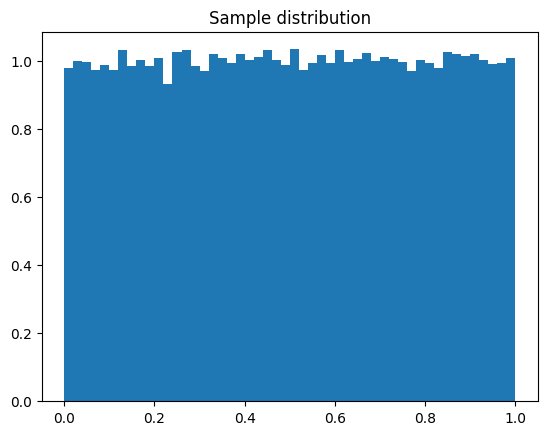

All tests passed!


In [3]:
from tests.tests import general_tests

# Run General Tests
rng = LCG(seed=42, a=a, c=c, m=modulus)

general_tests(lambda: rng.next(), plot=True)

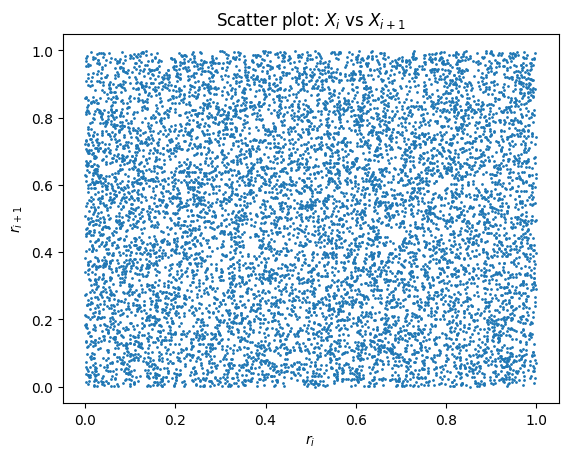

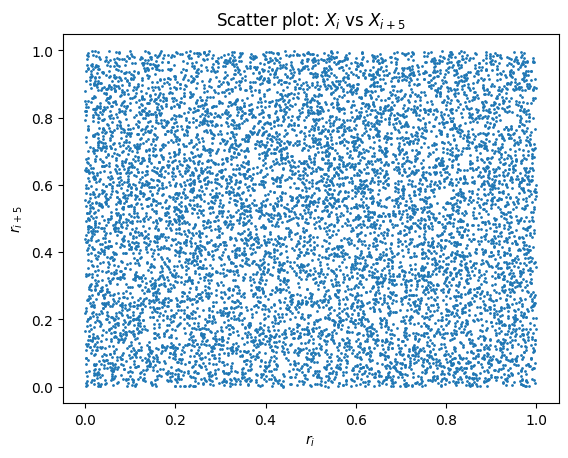

Widget(value='<iframe src="http://localhost:65510/index.html?ui=P_0x1d3aca742f0_0&reconnect=auto" class="pyvis…

In [4]:
# Some Visual Tests also help

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

# similar to what we already done in the lecture
samples = np.array([rng.next() for _ in range(10000)])

plt.scatter(samples[:-1], samples[1:], s=1)
plt.title("Scatter plot: $X_i$ vs $X_{i+1}$")
plt.xlabel("$r_i$")
plt.ylabel("$r_{i+1}$")
plt.show()

k = 5 
plt.scatter(samples[:-k], samples[k:], s=1)
plt.title(f"Scatter plot: $X_i$ vs $X_{{i+{k}}}$")
plt.xlabel("$r_i$")
plt.ylabel(f"$r_{{i+{k}}}$")
plt.show()

# Spectral Test (as above, just with r_i, r_{i+1}, r_{i+2})
points = np.array([[samples[i], samples[i+1], samples[i+2]] for i in range(len(samples)-2)])

# cannot figure out pyvista and latex formulas
cloud = pv.PolyData(points)
plotter = pv.Plotter()
plotter.add_points(cloud, render_points_as_spheres=True, point_size=5)
plotter.add_axes()
plotter.add_title("3D embedding: (X_i, X_{i+1}, X_{i+2})")
plotter.show()

The second set of test is more specific and contains some more detailed analysis. These take some inspiration from the *Diehard* set of tests.

### **Period Length**
The period lenght, or full cycle, refers to the point where the random generator comes back to the first state (the seed state) and begins to loop again from the start. This is obviously bad for a PRNG, as at that point every output becomes predicable. There is no general method to determine whether a PRNG algorithm is full-cycle short.

A benefit of LCGs is that an appropriate choice of parameters results in a period which is both known and long. 

In [5]:
from tests.tests import estimate_period

modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

rng = LCG(seed=seed, a=a, c=c, m=modulus)

period = estimate_period(lambda: rng.next(), 100000)

print(f"Estimated period: {period}")

No cycle detected within max iterations
Estimated period: None


### **Birthday Spacing Test**

Choose random points on a large interval with the PRNG to test. The spacings between the points should be asymptotically exponentially distributed, and repetition should be avoided. The name is based on the birthday paradox.

In [15]:
from tests.tests import birthday_spacings_test

modulus = 2**32
a = 1664525
c = 1013904223
seed = 42

lcg = LCG(seed=42)

birthday_spacings_test(lambda: lcg.next(), N=1000, bins=100)

# For perfect continuous uniform random numbers, repeated spacings should be rare.
# LCGs with poor lattice structure may show repeating spacings quite often.
# This test can reveal weaknesses that simple histogram tests completely miss.

Running Birthday Spacings Test...
Total unique spacings: 1
Total collisions: 998
High number of collisions, possible non-randomness.


### **Results**

The LCGs are a powerful category of PRNG, whose goodness heavily rely on the choice of the initial parameters. A bad choice can lead to problems, such as in the case of the RANDU generator (https://en.wikipedia.org/wiki/RANDU). With a good choice of parameters, one gets a fully deterministic PRNGS which satisifies many statistical tests (not all!).

## **Mersenne Twister**


In [ ]:
# Example Usage of MT

tests

In [8]:
# Run Tests

summarize and analyse results

## **Numpy's approach to randomness**
see what numpy does?

In [9]:
# Show off the methods

tests

In [10]:
# Run Tests

## **Simulations with different PRNGs**
We have seen different simulations with different PRNGs, but let's also take a look at one simulation with all of the analyzed generators -> more astro?